<h1><center>COVID-19. Детекция Атипичной пневмонии по рентгеновским снимкам</center></h1>

<center><img src = "https://ichef.bbci.co.uk/news/800/cpsprodpb/1EA6/production/_110764870_coronavirusmedium.jpg.webp" width = "750" height = "500"/></center>

<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:blue; border:0; color:white' role="tab" aria-controls="home"><center>[Предсказания]</center></h2>

# Импорт Библиотек

In [22]:
import numpy as np 
import pandas as pd 
from datetime import datetime
import time
import matplotlib.pyplot as plt

import os, json, cv2, random
import skimage.io as io
import copy
import logging
import pickle
from pathlib import Path
from typing import Optional
from typing import Any, Dict, List
from tqdm import tqdm
from math import ceil

import torch

import warnings

import config
from config import Flags
from COVID19_dict import build_COVID19_data_dicts_test

In [2]:
# detectron2
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import ColorMode

In [3]:
warnings.filterwarnings('ignore')

## Configs

In [4]:
flags = Flags()
flags.debug = False
print(flags)

Flags(debug=False, outdir='./output/', imgdir_name='./dataset/resized_pics', split_mode='all_train', iter=10000, warm_up_iters=1000, ims_per_batch=2, num_workers=4, lr_scheduler_name='WarmupMultiStepLR', base_lr=0.00025, roi_batch_size_per_image=512, eval_period=10000, aug_kwargs={})


In [5]:
classes = [
    "atypical",
    "indeterminate",
    "negative",
    "typical"
]

debug=flags.debug
outdir = Path(flags.outdir)
split_mode=flags.split_mode # Or  "all_train"

category_name_to_id = {
    class_name: index for index, class_name in enumerate(classes)
}

print(category_name_to_id)

{'atypical': 0, 'indeterminate': 1, 'negative': 2, 'typical': 3}


# Загрузка тестовых данных

In [6]:
imdir = flags.imgdir_name
df_meta = pd.read_csv(f"{config.DATA_ROOT_RESIZED}/meta_1.csv")

In [7]:
DatasetCatalog.register(
    "COVID19_data_test", lambda: build_COVID19_data_dicts_test(imdir,debug=debug)
)

In [8]:
MetadataCatalog.get("COVID19_data_test").set(thing_classes=classes)
metadata = MetadataCatalog.get("COVID19_data_test")
dataset_dicts = build_COVID19_data_dicts_test(imdir, debug=debug)

Creating the data ==> ...
image shape: (1024, 1024, 3)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1263/1263 [00:00<00:00, 23889.52it/s]


In [9]:
len(dataset_dicts)

1263

# Загрузка Модели

In [29]:
cfg = get_cfg()
config_name = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml" 
#config_name = "COCO-Detection/faster_rcnn_R_101_C4_3x.yaml"
cfg.merge_from_file(model_zoo.get_config_file(config_name))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4
cfg.MODEL.WEIGHTS = f'{flags.outdir}/model_final.pth'
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4 # set the testing threshold for this model
predictor = DefaultPredictor(cfg)

In [30]:
def format_pred(labels: np.ndarray, boxes: np.ndarray, scores: np.ndarray) -> str:
    pred_strings = []
    for label, score, bbox in zip(labels, scores, boxes):
        xmin, ymin, xmax, ymax = bbox.astype(np.int64)
        if label==2:
            labelstr='none'
        else:
            labelstr='opacity'
        pred_strings.append(f"{labelstr} {score:0.3f} {xmin} {ymin} {xmax} {ymax}") 
    return " ".join(pred_strings)

def predict_batch(predictor: DefaultPredictor, im_list: List[np.ndarray]) -> List:
    with torch.no_grad():  # https://github.com/sphinx-doc/sphinx/issues/4258
        inputs_list = []
        for original_image in im_list:
            # Apply pre-processing to image.
            if predictor.input_format == "RGB":
                # whether the model expects BGR inputs or RGB
                original_image = original_image[:, :, ::-1]
            height, width = original_image.shape[:2]
            # Do not apply original augmentation, which is resize.
            # image = predictor.aug.get_transform(original_image).apply_image(original_image)
            image = original_image
            image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))
            inputs = {"image": image, "height": height, "width": width}
            inputs_list.append(inputs)
        predictions = predictor.model(inputs_list)
        return predictions

# Предсказания

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1263/1263 [05:25<00:00,  3.88it/s]


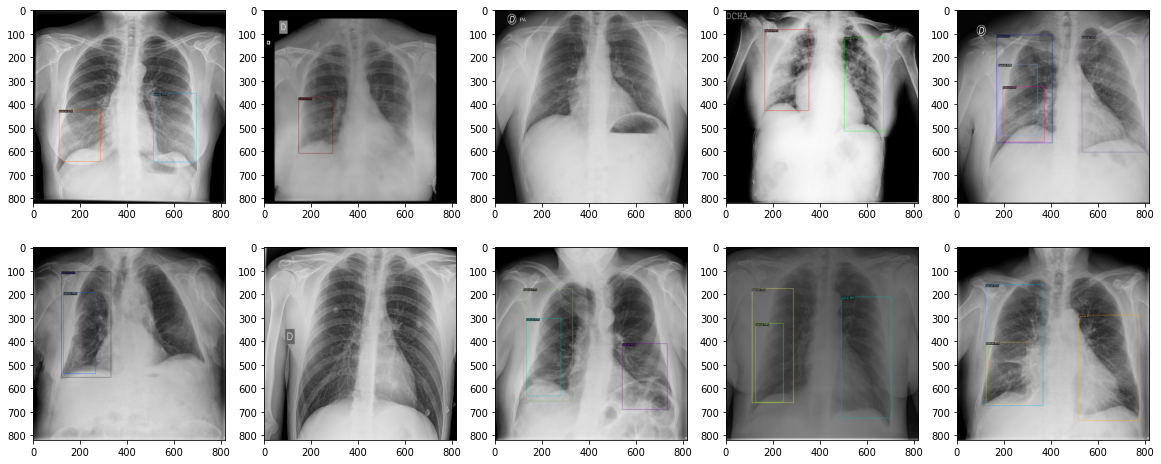

In [31]:
if debug:
    dataset_dicts = dataset_dicts[:30]
    
    
results_list = []
index = 0
batch_size = 1

fig, ax = plt.subplots(2, 5, figsize =(20,8))
indices=[ax[0][0],ax[1][0],ax[0][1],ax[1][1],ax[0][2],ax[1][2],ax[0][3],ax[1][3],ax[0][4],ax[1][4] ]


for i in tqdm(range(ceil(len(dataset_dicts) / batch_size))):
    inds = list(range(batch_size * i, min(batch_size * (i + 1), len(dataset_dicts))))
    dataset_dicts_batch = [dataset_dicts[i] for i in inds]
    im_list = [cv2.imread(d["file_name"]) for d in dataset_dicts_batch]
    outputs_list = predict_batch(predictor, im_list)

    for im, outputs, d in zip(im_list, outputs_list, dataset_dicts_batch):
        resized_height, resized_width, ch = im.shape
        #############################################################

        if index < 10:
            # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
            v = Visualizer(
                im[:, :, ::-1],
                metadata=metadata,
                scale=0.8,
                instance_mode=ColorMode.IMAGE_BW
                # remove the colors of unsegmented pixels. This option is only available for segmentation models
            )
            out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
            
            #cv2.imwrite(f"./pred_{index}.jpg", out.get_image()[:, :, ::-1])
            
            indices[index].grid(False)
            indices[index].imshow(out.get_image()[:, :, ::-1])
            
                        
         ###############################################################   
            
            
        df_meta = pd.read_csv(f"{config.DATA_ROOT_RESIZED}/meta_1.csv")
        test_meta=df_meta[df_meta.split=="test"]
        
        image_id, dim0, dim1,s = test_meta.iloc[index].values

        instances = outputs["instances"]
        if len(instances) == 0:
            result = {
                "image_id": image_id +"_image",
                "negative": 1,
                "typical": 0,
                "indeterminate": 0,
                "atypical": 0,
                 "PredictionString": "none 1 0 0 1 1"}
        else:
            fields: Dict[str, Any] = instances.get_fields()
            pred_classes = fields["pred_classes"]  # (n_boxes,)
            pred_scores = fields["scores"]
            pred_boxes = fields["pred_boxes"].tensor

            h_ratio = dim0 / resized_height
            w_ratio = dim1 / resized_width
            pred_boxes[:, [0, 2]] *= w_ratio
            pred_boxes[:, [1, 3]] *= h_ratio

            pred_classes_array = pred_classes.cpu().numpy()
            pred_boxes_array = pred_boxes.cpu().numpy()
            pred_scores_array = pred_scores.cpu().numpy()
            pred_classes_scores_array=np.stack((pred_classes_array,pred_scores_array), axis=-1)
            #{'atypical': 0, 'indeterminate': 1, 'negative': 2, 'typical': 3}
            
            
            typical= np.sum(pred_classes_scores_array[pred_classes_scores_array[:,0]==3, 1],axis=0)
            negative= np.sum(pred_classes_scores_array[pred_classes_scores_array[:,0]==2, 1],axis=0)
            indeterminate= np.sum(pred_classes_scores_array[pred_classes_scores_array[:,0]==1, 1],axis=0)
            atypical= np.sum(pred_classes_scores_array[pred_classes_scores_array[:,0]==0, 1],axis=0)
            
            total=typical+negative+indeterminate+atypical
            
            typical=typical/total
            negative=negative/total
            indeterminate=indeterminate/total
            atypical=atypical/total
            
                
            result = {
                "image_id": image_id +"_image",
                "negative": negative,
                "typical": typical,
                "indeterminate": indeterminate,
                "atypical": atypical,
                "PredictionString": format_pred(pred_classes_array, pred_boxes_array, pred_scores_array),
            }
        results_list.append(result)
        index += 1

In [32]:
df_img_pre=None
df_img_pre = pd.DataFrame(results_list)
df_img_pre

,image_id,negative,typical,indeterminate,atypical,PredictionString
0,89426c0c18a8_image,0.0,1.0,0.0,0.0,opacity 0.547 1789 1234 2426 2251 opacity 0.42...
1,27a4a0d2b7ec_image,0.0,1.0,0.0,0.0,opacity 0.779 471 675 960 1878 opacity 0.654 4...
2,8180af690aef_image,0.0,1.0,0.0,0.0,opacity 0.499 758 1581 1513 2585
3,4acbd31eafd5_image,1.0,0.0,0.0,0.0,none 1 0 0 1 1
4,c3afb9da2ebc_image,1.0,0.0,0.0,0.0,none 1 0 0 1 1
...,...,...,...,...,...,...
1258,11b8e5179115_image,0.0,1.0,0.0,0.0,opacity 0.525 1410 509 2209 1720 opacity 0.477...
1259,d393233d1b40_image,1.0,0.0,0.0,0.0,none 1 0 0 1 1
1260,363fbf00088c_image,1.0,0.0,0.0,0.0,none 1 0 0 1 1
1261,3b7ae6879147_image,1.0,0.0,0.0,0.0,none 1 0 0 1 1
